# ДИПЛОМНЫЙ ПРОЕКТ "Анализ программы лояльности"


Магазин строительных материалов «Строили, строили и наконец построили» ввел для клиентов систему лояльности. 
Все покупатели могут получить доступ в магазин с использованием персональных карт. За 200 рублей в месяц они могут стать участниками программы лояльности. В программу включены скидки, специальные предложения, подарки.


**Целью проекта** является оценка результатов внедрения системы лояльности путем сравнения ключевых метрик и проверки статистических гипотез на предоставленной выборке.

Датасет включает в себя информацию по покупках пользователей за 3 месяца во всех магазинах сети, факт их участия в программе лояльности и данные о ценах на весь ассортимент товаров.

- `purchaseId` — id чека;
- `item_ID` — id товара;
- `purchasedate` — дата покупки;
- `Quantity` — количество товара;
- `CustomerID` — id покупателя;
- `ShopID` — id магазина;
- `loyalty_program` — участвует ли покупатель в программе лояльности;
- `productID` — id товара;
- `price_per_one` — стоимость одной единицы товара;



## 1. Загрузка и предобработка данных

- Приведение данных к нужным типам;
- Обработка пропусков и аномалий (в данных встречаются отрицательные значения цен, нулевые значения количества товаров и цен)
- Расчет выручки, количества проданных товаров по месяцам (для участников программы лояльности и остальных покупателей). Визуализация результатов.

## 2. Анализ данных

- Описание поведения клиентов, исходя из выборки;
- Какой объем выручки и количество проданных товаров приходится на каждого покупателя в месяц;
- Расчет среднего количества, дисперсии и стандартного отклонения;
- Гистограммы, описание распределений;


## 3. Проверка гипотез

- Cредний чек участников системы лояльности и остальных покупателей различается;
- Глубина чека участников системы лояльности больше, чем у остальных покупателей;

## 4. Общие выводы по проекту

Оценка результатов системы лояльности, рекомендации по работе с данной программой.

______________________________________________________________________________________________________

## 1. Загрузка и предобработка данных



Загрузим файлы с данными и подготовим их для нашего исследования.

In [159]:
import pandas as pd
from matplotlib import pyplot as plt
from math import factorial
import numpy as np
import seaborn as sns
import scipy as sp
from scipy import stats
from scipy import stats as st

In [160]:
retail = pd.read_csv('retail_dataset.csv')
retail.head()

,purchaseid,item_ID,Quantity,purchasedate,CustomerID,ShopID,loyalty_program
0,538280,21873,11,2016-12-10 12:50:00,18427.0,Shop 0,0.0
1,538862,22195,0,2016-12-14 14:11:00,22389.0,Shop 0,1.0
2,538855,21239,7,2016-12-14 13:50:00,22182.0,Shop 0,1.0
3,543543,22271,0,2017-02-09 15:33:00,23522.0,Shop 0,1.0
4,543812,79321,0,2017-02-13 14:40:00,23151.0,Shop 0,1.0


Основной датасет **`retail`** содержит данные о каждой покупке с указанием id чека, id товара, даты совершения покупки, id клиента, магазина сети и факта участия в программе лояльности.

In [161]:
product = pd.read_csv('product_codes.csv')
product.head()

,productID,price_per_one
0,85123A,2.55
1,71053,3.39
2,84406B,2.75
3,84029G,3.39
4,84029E,3.39


Второй датасет **`product`** содержит коды товаров и цены за единицу товара.

Для начала, для удобства обращения к датасетам, приведем названия всех столбцов к нижнему регистру и переименуем некоторые из них:

In [162]:
retail.columns = retail.columns.str.lower()
retail = retail.rename({'purchaseid':'purchase_id',
                        'purchasedate':'purchase_date',
                        'customerid':'customer_id',
                        'shopid': 'shop_id'}, axis=1)
retail.head()

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program
0,538280,21873,11,2016-12-10 12:50:00,18427.0,Shop 0,0.0
1,538862,22195,0,2016-12-14 14:11:00,22389.0,Shop 0,1.0
2,538855,21239,7,2016-12-14 13:50:00,22182.0,Shop 0,1.0
3,543543,22271,0,2017-02-09 15:33:00,23522.0,Shop 0,1.0
4,543812,79321,0,2017-02-13 14:40:00,23151.0,Shop 0,1.0


In [163]:
product = product.rename({'productID':'item_id'}, axis=1)
product.head()
                          

,item_id,price_per_one
0,85123A,2.55
1,71053,3.39
2,84406B,2.75
3,84029G,3.39
4,84029E,3.39


In [164]:
len(product)

9969

In [165]:
len(retail['item_id'].value_counts())

3159

Судя по размерам датасетов, на каждый тип товара в таблице с ценами может приходиться по несколько значений. Это нормальная ситуация, цена на товар может постоянно корректироваться. Для дальнейшей работы нам потребуется добавить к главной таблице цену за единицу товара каждого наименования.
В данной ситуации будет приемлемо взять средние значения цен на каждый товар за весь период данных.

Для этого рассчитаем среднюю цену по всем товарам:

In [166]:
price = round(product.groupby('item_id')['price_per_one'].mean(), 2).reset_index()
price.columns=['item_id', 'price']
price

,item_id,price
0,10002,1.38
1,10080,0.85
2,10120,0.21
3,10123C,0.65
4,10124A,0.42
...,...,...
3154,gift_0001_20,16.84
3155,gift_0001_30,25.26
3156,gift_0001_40,34.04
3157,gift_0001_50,42.55


И добавим новый столбец со средней ценной единицы товара к главной таблице `retail`:

In [167]:
retail = retail.merge(price, how='left', on='item_id')
retail.head()

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,price
0,538280,21873,11,2016-12-10 12:50:00,18427.0,Shop 0,0.0,1.81
1,538862,22195,0,2016-12-14 14:11:00,22389.0,Shop 0,1.0,2.77
2,538855,21239,7,2016-12-14 13:50:00,22182.0,Shop 0,1.0,1.47
3,543543,22271,0,2017-02-09 15:33:00,23522.0,Shop 0,1.0,4.30
4,543812,79321,0,2017-02-13 14:40:00,23151.0,Shop 0,1.0,7.01


В ходе исследования эффективности программы лояльности нам необходим будет показатель среднего чека, поэтому добавим сразу в таблицу `retail` столбец с выручкой по каждой проданной позиции (как произведение количества единиц товара и его средней цены):

In [168]:
retail['revenue'] = retail['quantity'] * retail['price']
retail.head()

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,price,revenue
0,538280,21873,11,2016-12-10 12:50:00,18427.0,Shop 0,0.0,1.81,19.91
1,538862,22195,0,2016-12-14 14:11:00,22389.0,Shop 0,1.0,2.77,0.00
2,538855,21239,7,2016-12-14 13:50:00,22182.0,Shop 0,1.0,1.47,10.29
3,543543,22271,0,2017-02-09 15:33:00,23522.0,Shop 0,1.0,4.30,0.00
4,543812,79321,0,2017-02-13 14:40:00,23151.0,Shop 0,1.0,7.01,0.00


Для исследования в дальнейшем нам понадобятся суммы чеков, поэтому рассчитаем их значения и добавим в таблицу `retail`:

Добавим так же расчет количества приобретенных товаров по каждому чеку (глубину чека):

### 1.1 Тип данных 

Проверим типы данных всех столбцов и приведем их к нужному формату:

In [169]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105335 entries, 0 to 105334
Data columns (total 9 columns):
purchase_id        105335 non-null object
item_id            105335 non-null object
quantity           105335 non-null int64
purchase_date      105335 non-null object
customer_id        69125 non-null float64
shop_id            105335 non-null object
loyalty_program    105335 non-null float64
price              105335 non-null float64
revenue            105335 non-null float64
dtypes: float64(4), int64(1), object(4)
memory usage: 8.0+ MB


Для отслеживания динамики продаж, добавим в таблицу  столбец с указанием месяца. Предварительно приведем столбец `purchase_date` к типу даты:

In [170]:
retail['purchase_date'] = pd.to_datetime(retail['purchase_date'])

In [171]:
retail['month'] = retail['purchase_date'].astype('datetime64[M]')

In [172]:
retail.head()

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,price,revenue,month
0,538280,21873,11,2016-12-10 12:50:00,18427.0,Shop 0,0.0,1.81,19.91,2016-12-01
1,538862,22195,0,2016-12-14 14:11:00,22389.0,Shop 0,1.0,2.77,0.00,2016-12-01
2,538855,21239,7,2016-12-14 13:50:00,22182.0,Shop 0,1.0,1.47,10.29,2016-12-01
3,543543,22271,0,2017-02-09 15:33:00,23522.0,Shop 0,1.0,4.30,0.00,2017-02-01
4,543812,79321,0,2017-02-13 14:40:00,23151.0,Shop 0,1.0,7.01,0.00,2017-02-01


Полe  `loyalty_program` переведем в целочисленный тип данных:

In [173]:
retail['loyalty_program'] = retail['loyalty_program'].astype('int')

### 1.2 Обработка пропусков и аномалий


Заполним пропуски номеров карт **`customer_id`** значением "0" и посчитаем долю таких записей от общего числа чеков:

In [174]:
retail['customer_id'] = retail['customer_id'].fillna(0).astype('int')

In [175]:
len(retail.query('customer_id == "0"').groupby('purchase_id')) / len(retail['purchase_id'].value_counts())

0.1528402125051083

Около 15% чеков оказались не привязаны к клиентским картам. Причинами этого могли стать следующие ситуации:
- клиент имеет карту, но не предоставил ее при совершении покупки;
- клиент отказался от оформления карты и магазин провел покупку без ее использования
- имел место технический сбой и карта не считалась (возможно, она была повреждена, размагничена, кассир неправильно считал карту)

Теперь обратимся к данным в столбце с количеством проданного товара **`quantity`**:

In [176]:
retail['quantity'].describe()

count    105335.000000
mean          7.821218
std         327.946695
min      -74216.000000
25%           0.000000
50%           2.000000
75%           7.000000
max       74214.000000
Name: quantity, dtype: float64

Четверть товаров в чеках пробита в количестве 0 единиц либо с отрицательным значением


In [177]:
retail.query('quantity < 0'). head()

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,price,revenue,month
64,C539944,22776,-2,2016-12-23 11:38:00,20239,Shop 0,0,14.70,-29.40,2016-12-01
109,C542910,20726,-2,2017-02-01 15:38:00,23190,Shop 0,1,3.07,-6.14,2017-02-01
112,C542426,22418,-25,2017-01-28 09:32:00,19825,Shop 0,0,1.66,-41.50,2017-01-01
253,C539726,22791,-11,2016-12-21 14:24:00,22686,Shop 0,1,1.82,-20.02,2016-12-01
344,C544034,21878,-2,2017-02-15 11:28:00,20380,Shop 0,0,1.21,-2.42,2017-02-01


*Отрицательное значение* количестве товара в чеке может возникать в случае:

- отмены покупки (по просьбе клиента или ошибке кассира), тогда в чеке будут товары и с положительным, и с отрицательным `quantity`

- при оформлении возврата, тогда в чеке все товары будут в отрицательном количестве и код чека будет начинаться с символа "С"


Прежде чем выдвинуть предположение о возможных причинах записей с нулевым количеством товара, выведем строки подобные строки датасета:

In [178]:
retail.query('quantity == 0'). head()

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,price,revenue,month
1,538862,22195,0,2016-12-14 14:11:00,22389,Shop 0,1,2.77,0.0,2016-12-01
3,543543,22271,0,2017-02-09 15:33:00,23522,Shop 0,1,4.30,0.0,2017-02-01
4,543812,79321,0,2017-02-13 14:40:00,23151,Shop 0,1,7.01,0.0,2017-02-01
5,538379,22965,0,2016-12-12 11:26:00,22805,Shop 0,1,3.07,0.0,2016-12-01
6,540468,22189,0,2017-01-07 13:55:00,0,Shop 0,0,5.28,0.0,2017-01-01


*Нулевое количество* встречается у разных кодов товаров, независимо от участия клиента в программе лояльности.

Такая ситуация возможна, когда в системе учета значатся "составные позиции", т.е. основной код всего набора пробивается в чеке в количестве 0, а его составляющие со своими кодами уже вбиваются в реальном количестве и в сумме формируют цену "набора".

Посмотрим, насколько число чеков с нулевым количеством товара рознится в магазинах сети:


In [179]:
zero_quantity = retail.query('quantity == 0')\
                      .groupby('shop_id')['purchase_id'] \
                      .nunique()\
                      .sort_values(ascending=False)
zero_quantity 

shop_id
Shop 0     1617
Shop 4       32
Shop 1       25
Shop 6       20
Shop 8        9
Shop 18       7
Shop 10       7
Shop 12       6
Shop 3        4
Shop 22       2
Shop 20       2
Shop 16       2
Shop 11       2
Shop 7        1
Shop 14       1
Shop 5        1
Shop 19       1
Name: purchase_id, dtype: int64

С огромным отрывом магазин `Shop 0` лидирует по числу чеков с нулевым значением `quantity`.
Можем предположить, что он является флагманским магазином сети с самым большим ассортиментом, в том числе и составных наборов. Некоторые магазины не имеют подобных позиций в чеках. Из этого можем сделат вывод, что это наиболее мелкие магазины (формата "У дома"), с небольшим ассортиментом недорогих товаров из категории самого необходимого.

In [180]:
shop_top = retail.groupby('shop_id')['revenue'].sum().sort_values(ascending=False)
shop_top

shop_id
Shop 0     1577639.51
Shop 3      103984.74
Shop 6       56583.67
Shop 4       51496.25
Shop 1       47599.69
Shop 2       40519.74
Shop 14      22806.50
Shop 8       16173.93
Shop 7       11116.54
Shop 19      10140.84
Shop 10       9828.04
Shop 12       6776.74
Shop 18       6241.36
Shop 5        6137.51
Shop 24       3917.51
Shop 16       3741.83
Shop 11       3512.61
Shop 25       3362.31
Shop 22       2908.92
Shop 26       2767.05
Shop 13       2444.03
Shop 9        2421.24
Shop 17       2233.49
Shop 27       2114.16
Shop 15       1718.41
Shop 28       1466.17
Shop 21       1256.77
Shop 20        909.88
Shop 30        742.96
Shop 29        202.30
Shop 23        -11.02
Name: revenue, dtype: float64

Общая сумма выручки по магазинам сети подтверждает наши предположения:
- магазин с номером 0 десятикратно превосходит по оборотам другие точки;
- магазины, не имеющие "составных позиций" в ассортименте находятся внизу рейтинга доходов, что подтверждает наше предположение - это самые мелкие точки сети.

Чеки с нулевым количеством товара встречаются ~ в 30% от общего количества чеков.
В данном случае замена или удаление "нулевых" данных могут исказить результаты исследования, поэтому оставляем нулевые значения количества. Эти аномалии не будут иметь сильного влияния при расчете среднего чека и глубины чека. При необходимости, мы в дальнейшем их отфильтруем.

Отрицтельные количества товара так же оставляем без изменений. Иначе, исключив возвратные позиции из расчетов, мы рискуем получить завышенные значения метрик среднего чека и глубины чека.

Теперь посмотрим на распределение параметра **`price`**:

In [181]:
retail['price'].describe()

count    105335.000000
mean          5.950133
std          95.833104
min           0.000000
25%           1.810000
50%           2.950000
75%           5.270000
max        9268.760000
Name: price, dtype: float64

Некоторые позиции имеют нулевую цену. Посмотрим кодировки данных товаров и магазины, в которых они встречаются:

In [182]:
retail.query('price==0')['item_id'].unique()

array(['84247C', '84611B', '85028S', '90091', '17011A', '85179B',
       '84967A', '85226A', '84966A', '35645', '90000C', '84455',
       'DCGS0074', 'DCGS0057', '84966B', '85028L', '90095', '79063C',
       '84509F', '20849', '35969', '84612B', '84964B', '84977',
       'DCGS0072', '62095B', '84227', 'DCGS0055', '84968B', '72814',
       '21653', '84689', '21282', '20864', '35951', '84670', '21134',
       '85018C', '35644', '72803B', '21805', '84664', '85110', '21841',
       '72038P', '35991', '84424A', '85044', '84526', '84967B', '21431',
       '20950', '84546', '20738', '22143', '90042B', '21589'],
      dtype=object)

In [183]:
retail.query('price==0').groupby('shop_id')['item_id'].count()

shop_id
Shop 0    59
Name: item_id, dtype: int64

Бесплатные товары имеют разные коды, но все они были приобретены во флагманском магазине.

Причиной обнуления цен может быть, например:

- участие товара в акции;
- корректировка цен в системе;
- временное обнуление цены в базе до поступления новой партии товара


Изменение или удаление подобных товаров может сказаться на корректности дальнейших расчетов, поэтому мы оставляем данные по ценам в представленном виде.

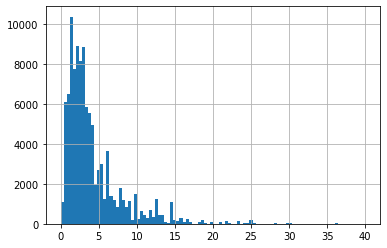

In [184]:
retail['price'].hist(bins=100, range=(0, 40))

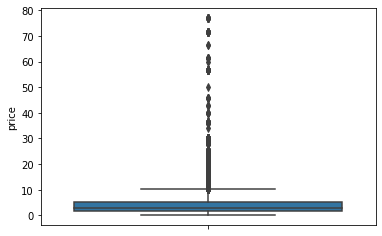

In [185]:
sns.boxplot(y='price', data=retail.query('price < 100'))

Судя по диаграммам и расчету основных метрик, цена  большинства приобретаемых товаров находится в диапазоне от 1 до 5 у.е.

На графике отчетливо видно большое число выбросов (цены выше 10 у.е.), поэтому при расчете средней цены мы ориентируемся на медианное значение - 3 у.е.



### 1.3 Расчет выручки и количества проданных товаров по группам клиентов


Обратимся к столбцу **`loyalty_program`** и рассчитаем процент участников программы лояльности среди всех клиентов из нашей выборки:

In [186]:
loyalty = retail.groupby('loyalty_program')['customer_id'].count().reset_index()
loyalty.columns = ['loyalty', 'sum_customer']
loyalty['percent'] = round(loyalty['sum_customer'] / loyalty['sum_customer'].sum(), 2)*100
loyalty

,loyalty,sum_customer,percent
0,0,81493,77.0
1,1,23842,23.0


В программе лояльности участвует четвертая часть всех клиентов торговой сети.

### 1.3.1 
Теперь посмотрим, какую **`выручку`** магазинам приносят разные группы клиентов.

In [187]:
revenue_group = retail.groupby(['loyalty_program','month'])['revenue'].sum().reset_index()
revenue_group.columns = ['loyalty_program', 'month', 'revenue']
revenue_group

,loyalty_program,month,revenue
0,0,2016-12-01,490812.61
1,0,2017-01-01,553275.68
2,0,2017-02-01,336327.34
3,1,2016-12-01,281096.07
4,1,2017-01-01,146366.27
5,1,2017-02-01,194875.71


Построим график распределения выручки по месяцам с учетом принадлежности клиентов к системе лояльности.

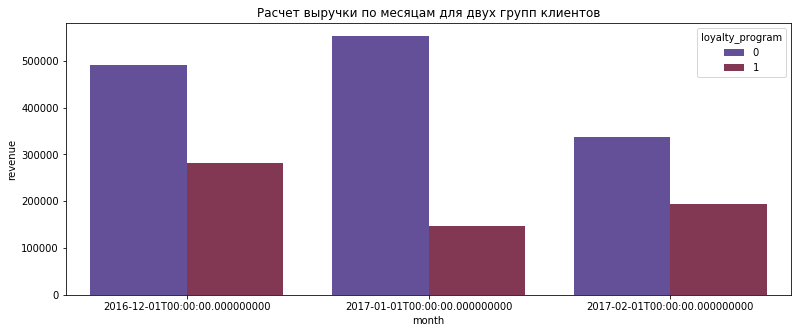

In [188]:
plt.figure(figsize=(13,5))

sns.barplot(data = revenue_group, x = revenue_group['month'],
            y = revenue_group['revenue'], hue='loyalty_program', palette='twilight')
plt.title('Расчет выручки по месяцам для двух групп клиентов')
plt.show()

<div class="alert alert-success">
<b>Комментарий тимлида:</b> Хороший график. Месяцы идут в хронологическом порядке.</div>

Теперь посмотрим, как распределилась выручка в целом:

In [189]:
revenue_month = retail.groupby('month')['revenue'].sum().reset_index()
revenue_month.columns=['month', 'revenue']
revenue_month['percent'] = round(revenue_month['revenue'] / revenue_month['revenue'].sum(),2)*100
revenue_month


,month,revenue,percent
0,2016-12-01,771908.68,39.0
1,2017-01-01,699641.95,35.0
2,2017-02-01,531203.05,27.0


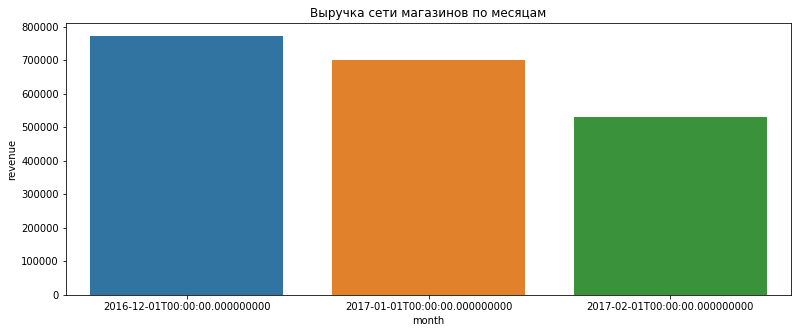

In [190]:
plt.figure(figsize=(13,5))
sns.barplot(data=revenue_month, x ='month', y='revenue')
plt.title('Выручка сети магазинов по месяцам')
plt.show()

Ожидаемо, прибыль от участников программы лояльности в абсолютном выражении ниже прибыли от других покупателей. 
Интересно, что прибыль внутри каждой группы по месяцам распределена по-разному:

- пик прибыли группы лояльности приходится на декабрь, а январь показал самые низкие результаты;
- в группе остальных клиентов пиковым месяцем был январь, а самый низкий результат был в феврале.

Видимо это связано с акциями для лояльных клиентов. Таким образом, управляя условиями акций, руководству сети удалось сохранить примерно равный результат за декабрь и январь, несмотря на праздничные (выходные) дни, но в феврале выручка заметно снизилась, несмотря на активность группы лояльных клиентов.



### 1.3.2

Теперь рассчитаем количество проданных товаров по группам лояльности за выбранный период:

In [191]:
quantity_group = retail.groupby(['loyalty_program', 'month'])['quantity'].sum().reset_index()
quantity_group

,loyalty_program,month,quantity
0,0,2016-12-01,211753
1,0,2017-01-01,215857
2,0,2017-02-01,167073
3,1,2016-12-01,87994
4,1,2017-01-01,57962
5,1,2017-02-01,83209


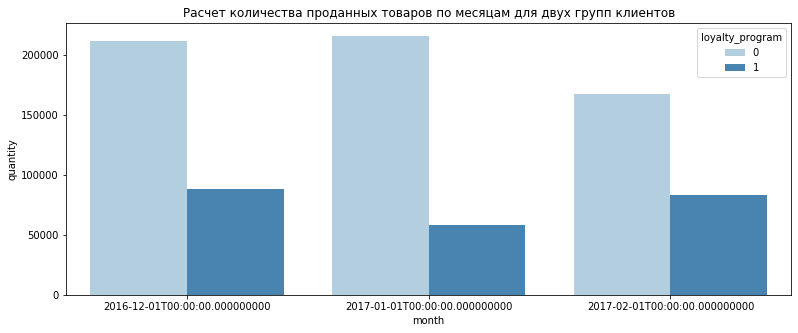

In [192]:
plt.figure(figsize=(13,5))

sns.barplot(data = quantity_group, x = quantity_group['month'], 
                                   y = quantity_group['quantity'], hue='loyalty_program',
                                   palette='Blues')
plt.title('Расчет количества проданных товаров по месяцам для двух групп клиентов')
plt.show()

In [193]:
quantity_month = retail.groupby('month')['quantity'].sum().reset_index()
quantity_month.columns=['month', 'quantity']
quantity_month['percent'] = round(quantity_month['quantity'] / quantity_month['quantity'].sum(),2)*100
quantity_month

,month,quantity,percent
0,2016-12-01,299747,36.0
1,2017-01-01,273819,33.0
2,2017-02-01,250282,30.0


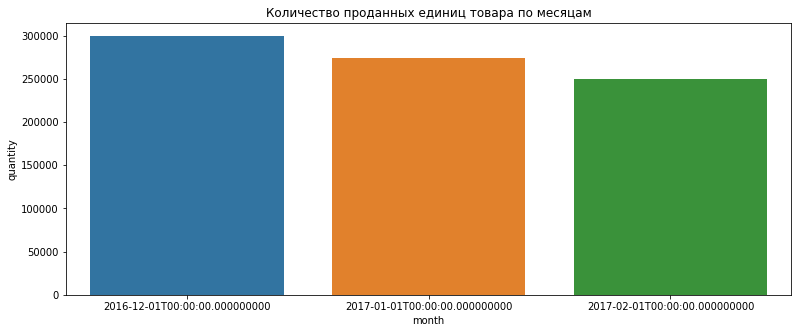

In [194]:
plt.figure(figsize=(13,5))
sns.barplot(data=quantity_month, x ='month', y='quantity')
plt.title('Количество проданных единиц товара по месяцам')
plt.show()

Ситуация по количеству проданных товаров схожа с расчетами выручки:

- в группе лояльных клиентов больше всего единиц товара приобреталось в декабре и феврале
- у остальных клиентов большее число товаров куплено в декабре и январе, а в феврале показатель заметно ниже

- разница в количестве приобретенных единиц товара по месяцам имеет не такой выраженный характер, как разница в выручке; т.е. товаров приобреталось больше товаров по меньшей стоимости


# Вывод:

- В первой части проета нами были загружены 2 датасета, содержащие данные по продажам в сети строительных магазинов за 3 месяца.

- Объединив датасеты, мы привели все столбцы к форматам в соответствии с их содержанием, выделили в отдельный столбец месяц продаж.

- В датасете были обнаружены аномальные (нулевые и отрицательные) значения цен и количества товаров. По каждой аномалии сделаны предположения о возможных причинах их появления в данных.

- Нами была рассчитана динамика полученной выручки (общей и с учетом программы лояльности), а так же количество проданных товаров за выбранный период (в целом и по группам клиентов)

- В целом, выручка по всем магазинам держалась на одном уровне в декабре и январе, но в феврале произошел спад. По группам лояльности ситуация рознится, можем предположить, что с помощью акций программы лояльности/управления ценами для остальных клиентов, руководству удалось снизить колебания на фоне праздничных дней.

- По количеству проданного товара по группам картина аналогична ситуации с выручкой, перепады по месяцам в целом более сглажены (это опять же может быть обусловлено акциями, стимулирующими к покупкам бОльшего числа товаров за меньшую стоимость)

- Поскольку за выбранный временной отрезок стоимость некоторых товаров изменялась (иногда несколько раз), в основную таблицу мы включили среднюю цену каждого артикула. В ценах на товары присутствует большое количество выбросов, исключив которые, мы можем говорить о медианном значении цены ~ 3 у.е.










# 2. Анализ данных

Описание поведения клиентов, исходя из выборки;
Какой объем выручки и количество проданных товаров приходится на каждого покупателя в месяц;
Расчет среднего количества, дисперсии и стандартного отклонения;
Гистограммы, описание распределений;

### 2.1 Количество товаров

Для оценки эффективности программы лояльности рассчитаем объем выручки и количество проданных товаров приходится на каждого покупателя в месяц.

In [195]:
sales_per_cust = retail.groupby(['month', 'loyalty_program'])['customer_id'].nunique(). reset_index()
sales_per_cust.columns=['month', 'loyalty_program', 'customer_unique']


In [196]:
sales_per_cust = sales_per_cust.merge(quantity_group, how='left', on=['month','loyalty_program'])
sales_per_cust

,month,loyalty_program,customer_unique,quantity
0,2016-12-01,0,605,211753
1,2016-12-01,1,344,87994
2,2017-01-01,0,545,215857
3,2017-01-01,1,239,57962
4,2017-02-01,0,529,167073
5,2017-02-01,1,270,83209


In [197]:
sales_per_cust = sales_per_cust.merge(revenue_group, how='left', on=['month', 'loyalty_program'])
sales_per_cust

,month,loyalty_program,customer_unique,quantity,revenue
0,2016-12-01,0,605,211753,490812.61
1,2016-12-01,1,344,87994,281096.07
2,2017-01-01,0,545,215857,553275.68
3,2017-01-01,1,239,57962,146366.27
4,2017-02-01,0,529,167073,336327.34
5,2017-02-01,1,270,83209,194875.71


In [198]:
sales_per_cust['revenue_per_cust'] = sales_per_cust['revenue'] / sales_per_cust['customer_unique']
sales_per_cust['quantity_per_cust'] = sales_per_cust['quantity'] / sales_per_cust['customer_unique']
sales_per_cust

,month,loyalty_program,customer_unique,quantity,revenue,revenue_per_cust,quantity_per_cust
0,2016-12-01,0,605,211753,490812.61,811.260512,350.004959
1,2016-12-01,1,344,87994,281096.07,817.139738,255.796512
2,2017-01-01,0,545,215857,553275.68,1015.184734,396.067890
3,2017-01-01,1,239,57962,146366.27,612.411172,242.518828
4,2017-02-01,0,529,167073,336327.34,635.779471,315.827977
5,2017-02-01,1,270,83209,194875.71,721.761889,308.181481


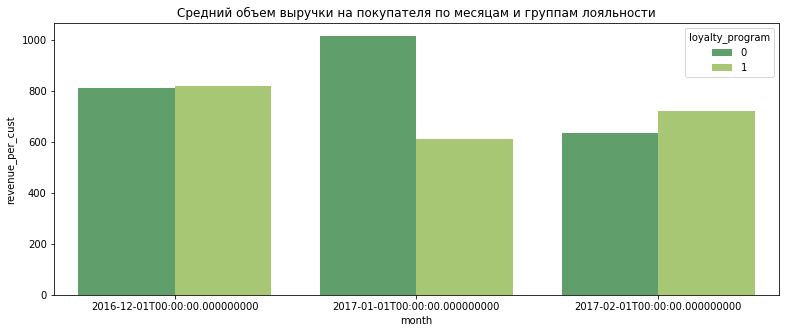

In [199]:
plt.figure(figsize=(13,5))
sns.barplot(data=sales_per_cust, x='month', y='revenue_per_cust', hue='loyalty_program', palette='summer')
plt.title('Средний объем выручки на покупателя по месяцам и группам лояльности')
plt.show()

По выборке за три месяца можно сделать следующие выводы **о среднем объеме выручки на покупателя:**
* в декабре и январе средняя выручка на покупателя по обеим группам были практически равны
* в январе показатель группы лояльности на 40% хуже группы остальных покупателей


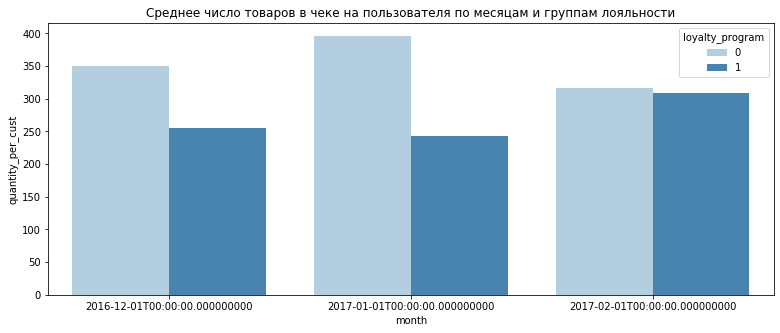

In [200]:
plt.figure(figsize=(13,5))
sns.barplot(data=sales_per_cust, x='month', y='quantity_per_cust', hue='loyalty_program', palette='Blues')
plt.title('Среднее число товаров в чеке на пользователя по месяцам и группам лояльности')
plt.show()

По всем месяцам показатели **среднего количества товаров на одного покупателя** группы лояльности ниже группы остальных клиентов.

Рассчитаем **количество заказов на одного покупателя** по группам лояльности:

In [201]:
purchase_per_cust = retail.groupby('loyalty_program')\
                       .agg({'customer_id':'nunique', 'purchase_id':'count'})\
                       .reset_index()
purchase_per_cust.columns = ['loyalty_program','customer_cnt', 'purchase_cnt']
purchase_per_cust['purchase_per_cust'] = purchase_per_cust['purchase_cnt'] / purchase_per_cust['customer_cnt']
purchase_per_cust

,loyalty_program,customer_cnt,purchase_cnt,purchase_per_cust
0,0,1163,81493,70.071367
1,1,587,23842,40.616695


In [202]:
purchase_per_cust = retail.groupby(['month','loyalty_program'])\
                       .agg({'customer_id':'nunique', 'purchase_id':'count'})\
                       .reset_index()
purchase_per_cust.columns = ['month','loyalty_program','customer_cnt', 'purchase_cnt']
purchase_per_cust['purchase_per_cust'] = purchase_per_cust['purchase_cnt'] / purchase_per_cust['customer_cnt']
purchase_per_cust

,month,loyalty_program,customer_cnt,purchase_cnt,purchase_per_cust
0,2016-12-01,0,605,32488,53.699174
1,2016-12-01,1,344,9993,29.049419
2,2017-01-01,0,545,28421,52.148624
3,2017-01-01,1,239,6726,28.142259
4,2017-02-01,0,529,20584,38.911153
5,2017-02-01,1,270,7123,26.381481


Покупатели, не участвующие в программе лояльности, в целом сделали на 60% больше заказов в пересчете на 1 клиента. Этот показатель стабилен по всем трем месяцам.

###  2.2 Выручка
Посмотрим теперь на **распределение выручки в расчете на одного клиента** по каждой группе лояльности нашей выборки:

In [203]:
rev_client = retail.query('revenue>0')\
          .groupby(['loyalty_program','customer_id'])['revenue'].sum()\
          .reset_index()
rev_client.columns=['loyalty_program','customer_id','revenue_client' ]
rev_client.head()

,loyalty_program,customer_id,revenue_client
0,0,0,229413.44
1,0,18025,77182.56
2,0,18026,1718.41
3,0,18027,1852.44
4,0,18029,385.18


Построим графики распределения выручки на одного покупателя по группам лояльности и рассчитаем основные метрики:

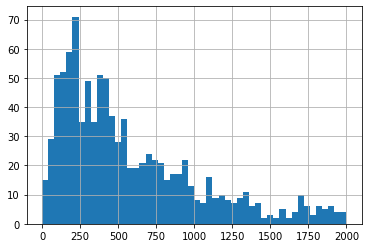

In [204]:
rev_client.query('loyalty_program==0')['revenue_client'].hist(bins=50, range=(0,2000))

In [205]:
rev_client.query('loyalty_program==0')['revenue_client'].describe()

count      1111.000000
mean       1669.924590
std        8474.028939
min           4.710000
25%         240.535000
50%         512.100000
75%        1113.785000
max      229413.440000
Name: revenue_client, dtype: float64

Среди клиентов, не участвующих в программе лояльности, средняя выручка на одного клиента составляет ~500 у.е. (из-за огромных выбросов стоит ориентироваться на медианное значение). В целом, большинство покупателей приносит сети магазинов чуть более 1000 у.е.

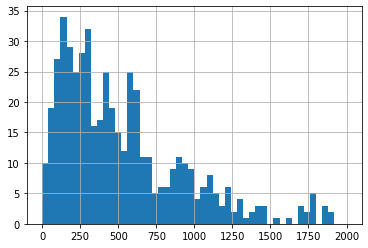

In [206]:
rev_client.query('loyalty_program==1')['revenue_client'].hist(bins=50, range=(0,2000))

In [207]:
rev_client.query('loyalty_program==1')['revenue_client'].describe()

count      561.000000
mean      1161.525758
std       3710.452246
min          2.440000
25%        236.850000
50%        479.760000
75%        942.020000
max      70019.700000
Name: revenue_client, dtype: float64

По участникам программы лояльности схожие показатели: есть огромные выбросы, медианное значение выручки на одного покупателя - 479 у.е., а большинство участников программы лояльности приносят магазину менее 1000 у.е. выручки.

Построим графики для определения выбросов по данной метрике:

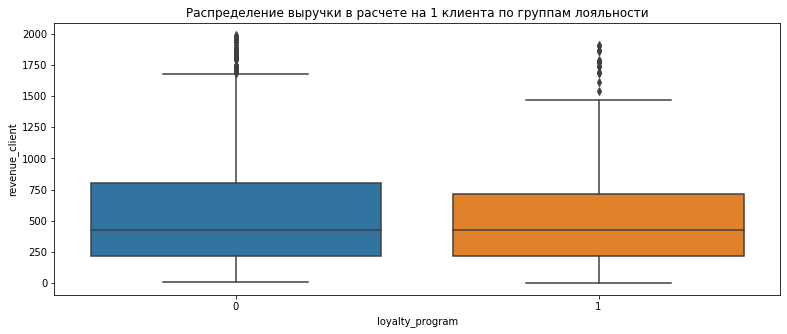

In [208]:
plt.figure(figsize=(13,5))
ax = sns.boxplot(x="loyalty_program", y ='revenue_client', data=rev_client.query('2000>revenue_client>0'))
ax.set_title('Распределение выручки в расчете на 1 клиента по группам лояльности')
plt.show()

Для участников системы лояльности выбросами можно считать выручку свыше 1500 у.е. на одного клиента, для остальных участников - свыше 1700 у.е.

Рассчитаем еще раз средние значения и квартили, исключивы выбросы:

In [209]:
rev_client.query('loyalty_program==0 and revenue_client <1700')['revenue_client'].describe()

count     927.000000
mean      518.213873
std       382.422568
min         4.710000
25%       210.010000
50%       415.590000
75%       748.000000
max      1687.660000
Name: revenue_client, dtype: float64

In [210]:
rev_client.query('loyalty_program==1 and revenue_client <1500')['revenue_client'].describe()

count     480.000000
mean      480.273208
std       342.766773
min         2.440000
25%       205.887500
50%       407.835000
75%       654.480000
max      1466.170000
Name: revenue_client, dtype: float64

Очистив данные от выбросов, можем сделать следующие выводы:

* участники программы лояльности в расчете на 1 клиента приносят магазину в среднем 400 у.е. выручки, большинство таких клиентов приносит 650 у.е., но в целом не более 1460 у.е

* остальные покупатели приносят магазину в среднем 400 у.е. выручки, большая части тратит ок.750 у.е., но в целом не более 1680 у.е

По данном показателю группа лояльности имеет показатели даже чуть ниже остальных покупателей.

 ### 2.3 Средний чек
 
 
 Рассчитаем показатели среднего чека для обеих групп покупателей.
 

In [211]:
avg_cheque_total= retail.groupby('loyalty_program')\
                   .agg({'purchase_id':'nunique', 'revenue':'sum'})\
                   .reset_index()
avg_cheque_total['avg_cheque'] = avg_cheque_total['revenue'] / avg_cheque_total['purchase_id']
avg_cheque_total

,loyalty_program,purchase_id,revenue,avg_cheque
0,0,3550,1380415.63,388.849473
1,1,1344,622338.05,463.049144


Средний чек группы лояльности на 17% выше показателя у группы остальных клиентов.
Посмотрим, как эта тенденция распределяется по месяцам:

In [212]:
avg_cheque_month = retail.groupby(['month', 'loyalty_program'])\
                   .agg({'purchase_id':'nunique', 'revenue':'sum'})\
                   .reset_index()
avg_cheque_month['avg_cheque'] = avg_cheque_month['revenue'] / avg_cheque_month['purchase_id']
avg_cheque_month

,month,loyalty_program,purchase_id,revenue,avg_cheque
0,2016-12-01,0,1418,490812.61,346.130190
1,2016-12-01,1,607,281096.07,463.090725
2,2017-01-01,0,1132,553275.68,488.759435
3,2017-01-01,1,344,146366.27,425.483343
4,2017-02-01,0,1000,336327.34,336.327340
5,2017-02-01,1,393,194875.71,495.866947


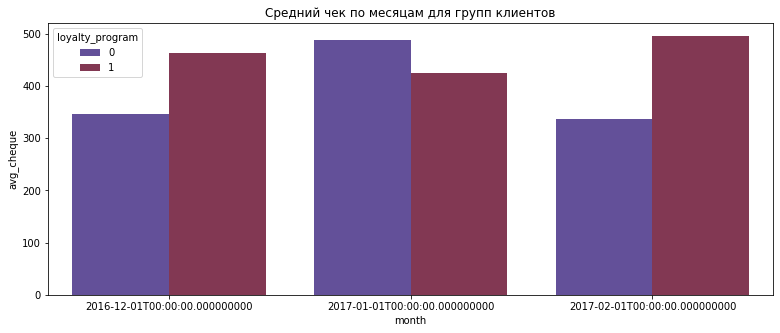

In [213]:
plt.figure(figsize=(13,5))
sns.barplot(data=avg_cheque_month, x='month', y='avg_cheque', hue='loyalty_program', palette='twilight')
plt.title('Средний чек по месяцам для групп клиентов')
plt.show()

Если рассматривать метрику по месяцам, то все не так однозначно: общее превышение суммы среднего чека достигнуто благодаря результатам декабря и особенно февраля. А вот в январе чек был выше у группы остальных клиентов.

Для дальнейшей проверки гипотез о различих в средних чеках подготовим данные по двум группам лояльности, рассчитаем их дисперсию, среднее и рассмотрим распределение этих величин.

In [214]:
cheque_0 = retail.query('loyalty_program==0').groupby('purchase_id')['revenue'].sum().reset_index()
cheque_0.columns=['purchase_id', 'sum_cheque_0']
cheque_0.head()

,purchase_id,sum_cheque_0
0,536367,295.57
1,536368,84.47
2,536369,16.60
3,536370,1237.32
4,536371,402.90


In [215]:
cheque_0['sum_cheque_0'].describe()

count     3550.000000
mean       388.849473
std       2707.407401
min     -77184.640000
25%          0.000000
50%        195.140000
75%        505.752500
max      77182.560000
Name: sum_cheque_0, dtype: float64

In [216]:
cheque_0['sum_cheque_0'].var()

7330054.83583131

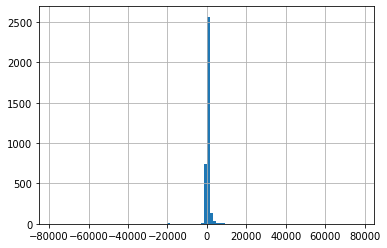

In [217]:
cheque_0['sum_cheque_0'].hist(bins=100)

In [218]:
cheque_1 = retail.query('loyalty_program==1').groupby('purchase_id')['revenue'].sum().reset_index()
cheque_1.columns=['purchase_id', 'sum_cheque_1']
cheque_1.head()

,purchase_id,sum_cheque_1
0,536365,184.49
1,536366,20.40
2,536372,20.40
3,536373,384.58
4,536375,384.58


In [219]:
cheque_1['sum_cheque_1'].describe()

count     1344.000000
mean       463.049144
std       1395.930890
min      -9389.490000
25%         69.167500
50%        223.995000
75%        482.740000
max      29018.860000
Name: sum_cheque_1, dtype: float64

In [220]:
cheque_1['sum_cheque_1'].var()

1948623.0501732808

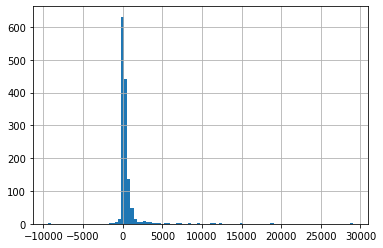

In [221]:
cheque_1['sum_cheque_1'].hist(bins=100)

Значения среднего чека у обеих групп лояльности распределены не нормально, присутсвует большое количество выбросов, дисперсии имеют существенное различие.

### 2.4 Глубина чека

Рассчитаем среднее количество товаров в чеке у двух групп лояльности:

In [222]:
cheque_cnt = retail.groupby('loyalty_program')\
                 .agg({'quantity':'sum','purchase_id':'nunique'})\
                 .reset_index()
cheque_cnt['cheque_cnt'] = cheque_cnt['quantity'] / cheque_cnt['purchase_id']
cheque_cnt

,loyalty_program,quantity,purchase_id,cheque_cnt
0,0,594683,3550,167.516338
1,1,229165,1344,170.509673


В целом по выборке показатели глубины чека практически равны у обеих групп покупателей.
Рассмотрим значение метрики по месяцам:

In [223]:
cheque_cnt_month = retail.groupby(['month','loyalty_program'])\
                 .agg({'quantity':'sum','purchase_id':'nunique'})\
                 .reset_index()
cheque_cnt_month['cheque_cnt'] = cheque_cnt_month['quantity'] / cheque_cnt_month['purchase_id']
cheque_cnt_month

,month,loyalty_program,quantity,purchase_id,cheque_cnt
0,2016-12-01,0,211753,1418,149.332158
1,2016-12-01,1,87994,607,144.965404
2,2017-01-01,0,215857,1132,190.686396
3,2017-01-01,1,57962,344,168.494186
4,2017-02-01,0,167073,1000,167.073000
5,2017-02-01,1,83209,393,211.727735


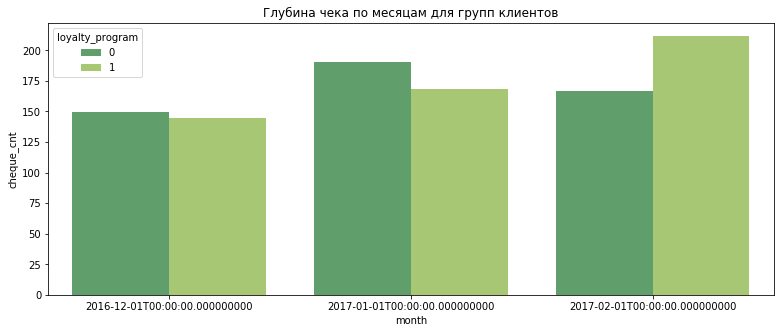

In [224]:
plt.figure(figsize=(13,5))
sns.barplot(data=cheque_cnt_month, x='month', y='cheque_cnt', hue='loyalty_program', palette='summer')
plt.title('Глубина чека по месяцам для групп клиентов')
plt.show()

При рассмотрении метрики по месяцам, мы видим что поазатели не были стабильно равными на протяжении всего периода выборки. Выский показатель группы лояльности в феврале скомпенсирован более низкими значениями в декабре и январе.

Для проверки гипотез о различиях в глубине чека двух групп лояльности, рассчитаем значения для каждого чека и оценим их распределение, дисперсию и ср.отклонение.

In [225]:
quantity_sum_0 = retail.query('loyalty_program==0').groupby('purchase_id')['quantity'].sum().reset_index()
quantity_sum_0.columns=['purchase_id', 'quantity_sum_0']
quantity_sum_0.head()

,purchase_id,quantity_sum_0
0,536367,71
1,536368,11
2,536369,2
3,536370,429
4,536371,79


In [226]:
quantity_sum_0['quantity_sum_0'].describe()

count     3550.000000
mean       167.516338
std       1832.036776
min     -74216.000000
25%          0.000000
50%         62.000000
75%        185.000000
max      74214.000000
Name: quantity_sum_0, dtype: float64

In [227]:
quantity_sum_0['quantity_sum_0'].var()

3356358.7496625506

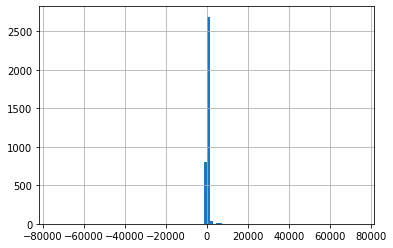

In [228]:
quantity_sum_0['quantity_sum_0'].hist(bins=100)

In [229]:
quantity_sum_1 = retail.query('loyalty_program==1').groupby('purchase_id')['quantity'].sum().reset_index()
quantity_sum_1.columns=['purchase_id', 'quantity_sum_1']
quantity_sum_1.head()

,purchase_id,quantity_sum_1
0,536365,33
1,536366,10
2,536372,10
3,536373,72
4,536375,72


In [230]:
quantity_sum_1['quantity_sum_1'].describe()

count    1344.000000
mean      170.509673
std       430.260407
min      -858.000000
25%        21.750000
50%        76.000000
75%       174.000000
max      5846.000000
Name: quantity_sum_1, dtype: float64

In [231]:
quantity_sum_1['quantity_sum_1'].var()

185124.0177768101

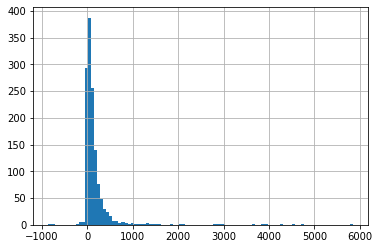

In [232]:
quantity_sum_1['quantity_sum_1'].hist(bins=100)

Значения глубины чека распределены не нормально, присутсвует большое количество выбросов. Дисперсии, ср.значения и ст.отклонение существенно различаются.

## Вывод:


В расчете *на одного покупателя* мы получили следующие результаты: 
- группой лояльности приобреталось меньше единиц товаров по всем месяцам (особенно в декабре и январе);
- выручка по группе лояльности была незначительно выше в декабре и феврале, но при этом значительно уступила группе остальных клиентов в январе;
- количество заказов сделанных на одного покупателя по группе лояльности ниже почти на 60%, чем в группе остальных покупателей.

Получив вышеописанные результаты, мы рассчитали *основые метрики* и пришли к следующим выводам:

- величина **среднего чека** в целом выше в группе лояльности, но этот показатель по месяцам нестабилен (превышение по гр.лоялности в декабре и феврале, а в январе показатель закономерно выше у группы остальных клиентов)
- **глубина чека** в целом по выборке практичсеки одинакова у обеих групп (в феврале значительно лидировала группа лояльности, а в декабре и январе - остальные клиенты приобретали больше товаров в расчете на один чек)  



# 3. Проверка гипотез

Поскольку значения выборок распределены ненормально, их дисперсии значимо различаются, для проверки гипотез мы будем использовать тест Уилкоксона-Манна-Уитни.


Для начала проверим **гипотезу о разнице средних чеков** двух групп покупателей: 

Н0 - средний чек покупателей из группы лояльности равен среднему чеку остальных покупателей,<br>
Н1 - средние чеки двух групп пользователей не равны

In [233]:
alpha = .05

In [234]:
results = st.mannwhitneyu(cheque_1['sum_cheque_1'], cheque_0['sum_cheque_0'])

print('p-значение: ', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу: разница статистически значима")
else:
    print("Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя") 


p-значение:  0.00021500663338444142
Отвергаем нулевую гипотезу: разница статистически значима


Теперь проверим гипотезу о разнице глубины чека по двум группам покупателей:

Н0 - глубина чека покупателей из группы лояльности равна глубине чека остальных покупателей,<br>
Н1 - глубина чека двух групп пользователей не равна

In [235]:
results = st.mannwhitneyu(quantity_sum_1['quantity_sum_1'], quantity_sum_0['quantity_sum_0'])

print('p-значение: ', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу: разница статистически значима")
else:
    print("Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя") 


p-значение:  9.219775553579713e-05
Отвергаем нулевую гипотезу: разница статистически значима


### Вывод:
По результатам проверки статистических гипотез мы не смогли подтвердить наши предположения о равенстве средних чеков и глубины чека клиентов.

# ВЫВОД ПО ПРОЕКТУ:

В данном проекте мы проанализировали покупательское поведение клиентов сети строительных магазинов.
Для оценки результатов внедрения программы лояльности нами были рассчитаны ключевые показатели и метрики, а так же проведены проверки статистических гипотез.
На основании наших расчетов мы можем сделать следующие выводы:

* Величина среднего чека в целом выше в группе лояльности, но этот показатель по месяцам нестабилен (превышение по гр.лояльности в декабре и феврале, а в январе показатель закономерно выше у группы остальных клиентов). Так же не подтвердилась стат. гипотеза о равенстве средних чеков по обеим группам.


* Глубина чека так же колеблется по месяцам (в феврале с большим отрывом лидировала группа лояльности, а в декабре ее значения были ниже группы остальных клиентов). Стат. гипотеза о равенстве глубины чека по двум группам так же не подтвердилась.

* Средняя выручка в расчете на одного покупателя по группе лояльности ниже группы остальных покупателей (и по сырым, и по очищенным от выбросов данным). Т.о. мы не можем однозначно утверждать об эффективности программы лояльности и повышении выручки от клиентов этой группы.

По результатам исследования мы можем рекомендоватьвнесли следующие рекомендации:

* Продолжить  внедрение программы лояльности и сбор данных по результатам ее работы для последующей оценки за более длительный срок. 
В нашем случае за 3 месяца не все клиенты могли быть оповещены о действии программы, а так же свое влияние внес и сезонный фактор - праздничные даты и снижение строительной активности в зимний период. Можем предположить, что весенне-летний всплеск спроса может дать более детаельное представление о действии программы лояльности.

* Пересмотреть программу предложений для клиентов из программы лояльности - они показывают меньшую выручку в расчете на одного покупателя, хотя по глубине чека они временами лидируют с большим отрывом, но это лидерство нестабильно. Возможно стоит чаще использовать акции типа "3+1", т.е. снижая выручку за единицу товара, мотивировать на увеличение глубины чека. 
Так же стимулом к увеличению числа товаров в чеке могут стать акции с прогрессирующей скидкой в зависимости от увеличения числа позиций в чеке.

* Необходимо коррелировать специальные предложения для группы лояльности и предложениями для всех покупателей. Судя по тому, что январь у группы лояльность был провальным по всем метрикам, в этом месяце условия для всех покупателей были явно выгоднее, а программа лояльности не предложила своим участникам ничего сверх общих условий.




ПРЕЗЕНТАЦИЯ: https://drive.google.com/file/d/1OrIIfXKwJLGONjiEJJcWqh3An3UJaZ4-/view?usp=sharing


ДАШБОРД: https://public.tableau.com/profile/irina1119#!/vizhome/Diplom_16140141432380/Dashboard1